# HNSCC Single-Cell RNA-seq Data Analysis

This notebook performs exploratory data analysis (EDA) on the **GSE103322 HNSCC** (Head and Neck Squamous Cell Carcinoma) dataset.

**Contents:**
- Data loading and preprocessing
- Numerical and categorical feature analysis  
- Correlation analysis
- Visualization of distributions and relationships with target variable

## 1. Setup and Configuration

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from pathlib import Path

ENV_PATH = os.environ.get('DATA_FILE')
FILE_PATH = Path(r'HNSCC_all_data.txt')
DELIMITER = '\t'
HEADER_ROW = 0
SKIP_ROWS = 0
TARGET_COLUMN = 'classified  as cancer cell'

NOTEBOOK_DIR = Path(os.getcwd())
CANDIDATE_PATHS = [
    FILE_PATH,
    NOTEBOOK_DIR / 'HNSCC_all_data.txt',
    NOTEBOOK_DIR.parent / 'HNSCC_all_data.txt',
    NOTEBOOK_DIR / 'GSE103322_HNSCC_all_data.txt' / 'HNSCC_all_data.txt',
    NOTEBOOK_DIR.parent / 'GSE103322_HNSCC_all_data.txt' / 'HNSCC_all_data.txt',
    Path('/mnt/c/Users/Tanzil/Downloads/GSE103322_HNSCC_all_data.txt/HNSCC_all_data.txt'),
    Path('/data/HNSCC_all_data.txt')
]
DATA_PATH = None
USE_SYNTHETIC = False

print('Checking candidate paths:')

if ENV_PATH:
    env_path = Path(ENV_PATH).expanduser()
    print(f'  DATA_FILE -> {env_path}')
    if env_path.exists():
        DATA_PATH = env_path

if DATA_PATH is None:
    for cand in CANDIDATE_PATHS:
        exists = cand.exists()
        print(f"  {cand} -> {'FOUND' if exists else 'missing'}")
        if exists:
            DATA_PATH = cand
            break

if DATA_PATH is None:
    USE_SYNTHETIC = True
    print('No data file found; a small synthetic dataset will be used for demos.')
else:
    print(f'Using data file: {DATA_PATH}')

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100

Checking candidate paths:
  HNSCC_all_data.txt -> missing
  /workspaces/codespaces-jupyter/HNSCC_all_data.txt -> missing
  /workspaces/HNSCC_all_data.txt -> missing
  /workspaces/codespaces-jupyter/GSE103322_HNSCC_all_data.txt/HNSCC_all_data.txt -> missing
  /workspaces/GSE103322_HNSCC_all_data.txt/HNSCC_all_data.txt -> missing
  /mnt/c/Users/Tanzil/Downloads/GSE103322_HNSCC_all_data.txt/HNSCC_all_data.txt -> missing
  /data/HNSCC_all_data.txt -> missing
No data file found; a small synthetic dataset will be used for demos.


## 2. Load and Prepare Data

In [10]:
if USE_SYNTHETIC:
    print('Loading synthetic demo dataset...')
    df = pd.DataFrame({
        'gene1': [1.2, 3.4, 2.1, 4.0, 0.5],
        'gene2': [0.2, 0.1, 0.4, 0.3, 0.6],
        'patient': ['A', 'A', 'B', 'B', 'C'],
        'classified  as cancer cell': [1, 1, 0, 0, 1],
    })
    print(f"✓ Synthetic data created! Shape: {df.shape}")
else:
    try:
        print(f"Loading data from: {DATA_PATH}...")
        df = pd.read_csv(DATA_PATH, sep=DELIMITER, header=HEADER_ROW, skiprows=SKIP_ROWS)
        print(f"✓ Data loaded successfully! Shape: {df.shape}")
    except Exception as e:
        raise Exception(f"Error loading data from {DATA_PATH}: {e}")

Loading synthetic demo dataset...
✓ Synthetic data created! Shape: (5, 4)


In [11]:
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors='ignore')

numerical_cols = df.select_dtypes(include=np.number).columns.tolist()
categorical_cols = df.select_dtypes(include=['object', 'category']).columns.tolist()

if TARGET_COLUMN in numerical_cols:
    numerical_cols.remove(TARGET_COLUMN)

print(f"Numerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")
print(f"Target column: '{TARGET_COLUMN}'")

Numerical columns: 2
Categorical columns: 1
Target column: 'classified  as cancer cell'


/tmp/ipykernel_5235/2884215013.py:3: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors='ignore')


## 3. Data Visualization

### 3.1 Numerical Feature Distributions

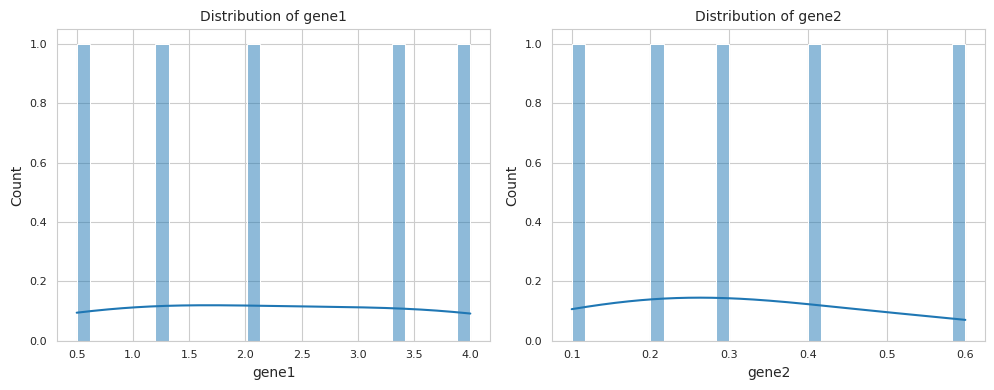

In [12]:
def plot_numerical_distributions(df, columns, n_cols=3):
    """Plot histograms for numerical features."""
    if not columns:
        print("No numerical columns to plot.")
        return
    
    n_rows = (len(columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    for i, col in enumerate(columns):
        sns.histplot(df[col].dropna(), kde=True, ax=axes[i], bins=30)
        axes[i].set_title(f'Distribution of {col}', fontsize=10)
        axes[i].tick_params(labelsize=8)
    
    for j in range(len(columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

if numerical_cols:
    plot_numerical_distributions(df, numerical_cols)
else:
    print("No numerical columns available for histogram plotting.")

### 3.2 Correlation Heatmap

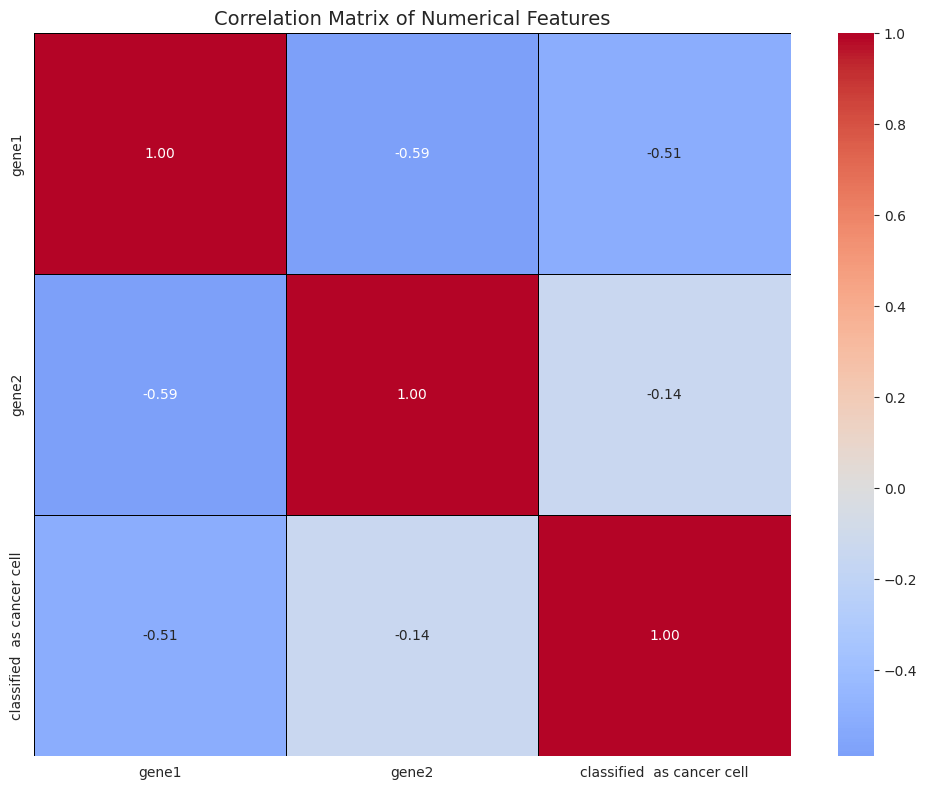

In [13]:
def plot_correlation_heatmap(df, columns, target_col=None):
    """Plot correlation matrix heatmap."""
    if len(columns) < 2:
        print("Need at least 2 numerical columns for correlation analysis.")
        return
    
    cols_to_use = columns.copy()
    if target_col and target_col in df.columns:
        cols_to_use.append(target_col)
    
    plt.figure(figsize=(10, 8))
    corr_matrix = df[cols_to_use].corr()
    sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', 
                linewidths=0.5, linecolor='black', center=0)
    plt.title('Correlation Matrix of Numerical Features', fontsize=14)
    plt.tight_layout()
    plt.show()

if len(numerical_cols) >= 2:
    plot_correlation_heatmap(df, numerical_cols, TARGET_COLUMN)
else:
    print("Insufficient numerical columns for correlation analysis.")

### 3.3 Categorical Feature Distributions

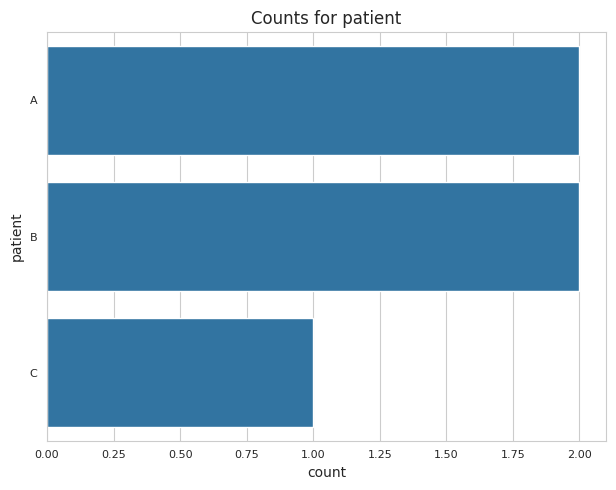

In [14]:
def plot_categorical_counts(df, columns, max_unique=20, n_cols=2):
    """Plot bar charts for categorical features."""
    plottable_cols = [col for col in columns if df[col].nunique() <= max_unique]
    
    if not plottable_cols:
        print(f"No categorical columns with ≤{max_unique} unique values to plot.")
        return
    
    n_rows = (len(plottable_cols) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    for i, col in enumerate(plottable_cols):
        sns.countplot(y=df[col], ax=axes[i], order=df[col].value_counts().index)
        axes[i].set_title(f'Counts for {col}', fontsize=12)
        axes[i].tick_params(labelsize=8)
    
    for j in range(len(plottable_cols), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

if categorical_cols:
    plot_categorical_counts(df, categorical_cols)
else:
    print("No categorical columns available for plotting.")

### 3.4 Feature vs Target Analysis (Box Plots)

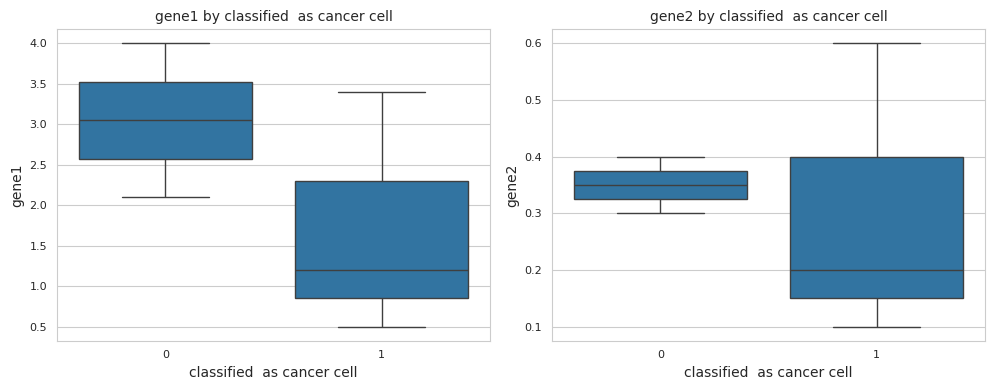

In [15]:
def plot_features_vs_target(df, num_columns, target_col, n_cols=3):
    """Plot box plots comparing numerical features across target classes."""
    if target_col not in df.columns:
        print(f"Target column '{target_col}' not found.")
        return
    
    if df[target_col].nunique() > 10:
        print(f"Target has too many unique values ({df[target_col].nunique()}) for box plots.")
        return
    
    if not num_columns:
        print("No numerical columns to plot.")
        return
    
    n_rows = (len(num_columns) + n_cols - 1) // n_cols
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
    axes = axes.flatten() if n_rows > 1 or n_cols > 1 else [axes]
    
    for i, col in enumerate(num_columns):
        sns.boxplot(x=df[target_col], y=df[col], ax=axes[i])
        axes[i].set_title(f'{col} by {target_col}', fontsize=10)
        axes[i].tick_params(labelsize=8)
    
    for j in range(len(num_columns), len(axes)):
        fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()

if TARGET_COLUMN in df.columns and numerical_cols:
    plot_features_vs_target(df, numerical_cols, TARGET_COLUMN)
else:
    print("Cannot create box plots: missing target column or numerical features.")

## Summary

Analysis complete! Review the visualizations above to understand:
- **Distributions**: How each feature is distributed
- **Correlations**: Relationships between numerical features
- **Target relationships**: How features differ across cancer/non-cancer cells